In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Path to your data folder
DATA_PATH = 'data/'

orders = pd.read_csv(DATA_PATH + 'orders.csv')
products = pd.read_csv(DATA_PATH + 'products.csv')
aisles = pd.read_csv(DATA_PATH + 'aisles.csv')
departments = pd.read_csv(DATA_PATH + 'departments.csv')
order_products_prior = pd.read_csv(DATA_PATH + 'order_products__prior.csv')

print("Data loading complete. Starting analysis...")

Data loading complete. Starting analysis...


In [5]:
# 1. Merge products, aisles, and departments
product_details = products.merge(aisles, on='aisle_id').merge(departments, on='department_id')
product_details = product_details[['product_id', 'product_name', 'aisle', 'department']]

# 2. Merge prior orders with product details
# This creates a transaction-level detail table
order_details = order_products_prior.merge(product_details, on='product_id', how='left')

# 3. Merge with orders to get user/time details (optional but useful for EDA)
master_df = order_details.merge(orders, on='order_id', how='left')

print("Master DataFrame created with shape:", master_df.shape)

Master DataFrame created with shape: (32434489, 13)


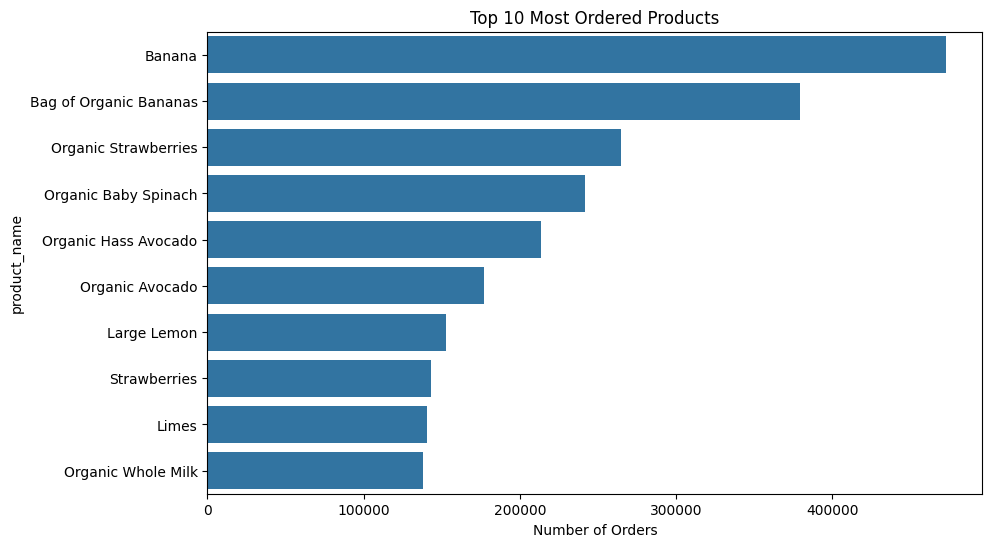

In [6]:
#Exploratory Data Analysis (EDA) 📈
#Most Popular Products:
top_products = master_df['product_name'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Most Ordered Products')
plt.xlabel('Number of Orders')
plt.show()

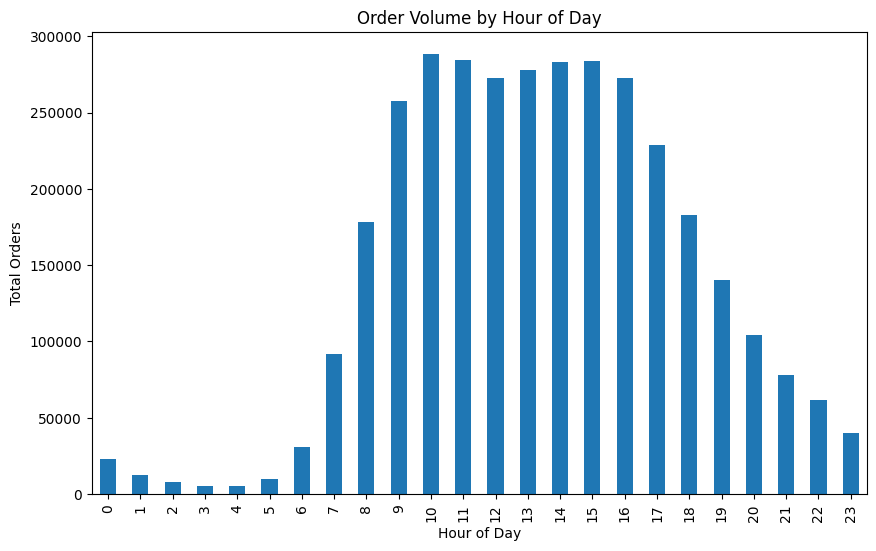

In [7]:
#Time Series Visualization (Orders by Day/Hour):

# Orders per hour of the day
plt.figure(figsize=(10, 6))
orders['order_hour_of_day'].value_counts().sort_index().plot(kind='bar')
plt.title('Order Volume by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Orders')
plt.show()


In [8]:
#Preparing Data for Apriori/Eclat (Transactional Format) 📝


#Group Products by Order

# Group products into lists, indexed by order_id
transaction_list = master_df.groupby('order_id')['product_name'].apply(list).tolist()

# Due to the large size of the full Instacart data (3M+ orders),
# it's best to sample/filter the data for initial Apriori/Eclat runs.
# For a full run, consider using a high-performance cluster or reducing item variety.

# Example: Filter to only the top 100 most frequent products to reduce computational load
top_100_products = master_df['product_name'].value_counts().head(100).index

# Filter master_df to only include the top products
filtered_df = master_df[master_df['product_name'].isin(top_100_products)]

# Re-create the transaction list from the filtered data
basket = filtered_df.groupby(['order_id'])['product_name'].apply(lambda x: ','.join(x.astype(str))).reset_index()
transactions = basket['product_name'].apply(lambda x: x.split(',')).tolist()

# Select a manageable sample for training if the list is still too large
# transactions_sample = transactions[:100000] # Use only 100k orders

print(f"Total transactions for MBA: {len(transactions)}")

Total transactions for MBA: 2351240


In [13]:
#One-Hot Encoding
import sys
!{sys.executable} -m pip install mlxtend

from mlxtend.preprocessing import TransactionEncoder


te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print("OHE Data Shape:", df_encoded.shape)

  Using cached mlxtend-0.23.4-py3-none-any.whl (1.4 MB)
  Using cached scikit_learn-1.7.2-cp310-cp310-win_amd64.whl (8.9 MB)
  Using cached scipy-1.15.3-cp310-cp310-win_amd64.whl (41.3 MB)
  Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


OHE Data Shape: (2351240, 101)


In [15]:
#Implementing Apriori and Association Rules
#Apply Apriori Algorithm
from mlxtend.frequent_patterns import apriori

# Find itemsets with a minimum support of 0.1% (0.001)
frequent_itemsets = apriori(df_encoded, min_support=0.05, use_colnames=True)

frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

print("Number of Frequent Itemsets:", len(frequent_itemsets))
print(frequent_itemsets.sort_values(by='support', ascending=False).head())

Number of Frequent Itemsets: 11
    support                  itemsets  length
1  0.200985                  (Banana)       1
0  0.161383  (Bag of Organic Bananas)       1
8  0.112572    (Organic Strawberries)       1
5  0.102891    (Organic Baby Spinach)       1
6  0.090839    (Organic Hass Avocado)       1


In [16]:
#Generate Association Rules

from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)

# Filter and sort the rules for analysis
rules = rules.sort_values(['lift', 'confidence'], ascending=[False, False])

print("\nTop 10 Association Rules (by Lift):")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


Top 10 Association Rules (by Lift):
Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


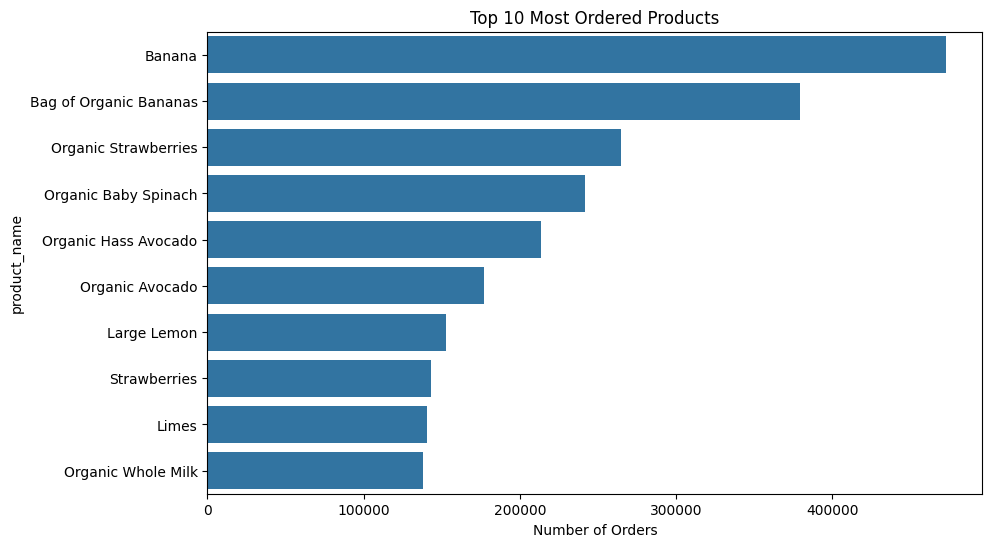

In [ ]:
#Exploratory Data Analysis (EDA) 📈
#Most Popular Products:
top_products = master_df['product_name'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Most Ordered Products')
plt.xlabel('Number of Orders')
plt.show()

In [20]:
#Visualization using ggplot
import sys
!{sys.executable} -m pip install plotnine
from plotnine import (
    ggplot, aes, geom_bar,
    scale_x_continuous, labs,
    theme_minimal, theme, element_text
)





[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
from plotnine import (
    ggplot,
    aes,
    geom_bar,
    scale_x_continuous,
    labs,
    theme_minimal,
    theme,
    element_text
)

# --- 1. Load Data (Assumed step from previous instructions) ---
# Replace 'data/orders.csv' with your actual path if needed
try:
    orders = pd.read_csv('data/orders.csv')
except FileNotFoundError:
    print("Error: orders.csv not found. Please ensure it's in the 'data/' folder.")
    # Create dummy data for demonstration if file is missing:
    orders = pd.DataFrame({
        'order_dow': [0, 1, 1, 2, 3, 3, 3, 4, 5, 6, 6, 6],
        'order_hour_of_day': [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
    })


# --- 2. Data Preparation: Count Orders by Day of Week (DOW) ---
# 0 = Sunday, 6 = Saturday (Instacart convention)
df_dow = orders['order_dow'].value_counts().reset_index()
df_dow.columns = ['order_dow', 'count']

# Map the numeric DOW to descriptive labels for better visualization
day_map = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
df_dow['day_name'] = df_dow['order_dow'].map(day_map)
df_dow = df_dow.sort_values('order_dow') # Sort numerically to keep day order

# --- 3. ggplot/plotnine Visualization Script ---

# The core concept: ggplot(data) + aes(x, y) + geom_TYPE()
plot = (
    ggplot(df_dow, aes(x='day_name', y='count'))
    + geom_bar(stat='identity', fill='#5a9e6d', width=0.7) # stat='identity' uses the 'count' column as the height
    + labs(
        title='Instacart Order Volume by Day of Week',
        x='Day of Week (0=Sunday, 6=Saturday)',
        y='Total Number of Orders (Millions)'
    )
    + theme_minimal()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotate x-axis labels
        plot_title=element_text(ha='center', size=14, weight='bold') # Center and bold the title
    )
)

# Display the plot in VS Code or Jupyter
print(plot)


<ggplot: (640 x 480)>


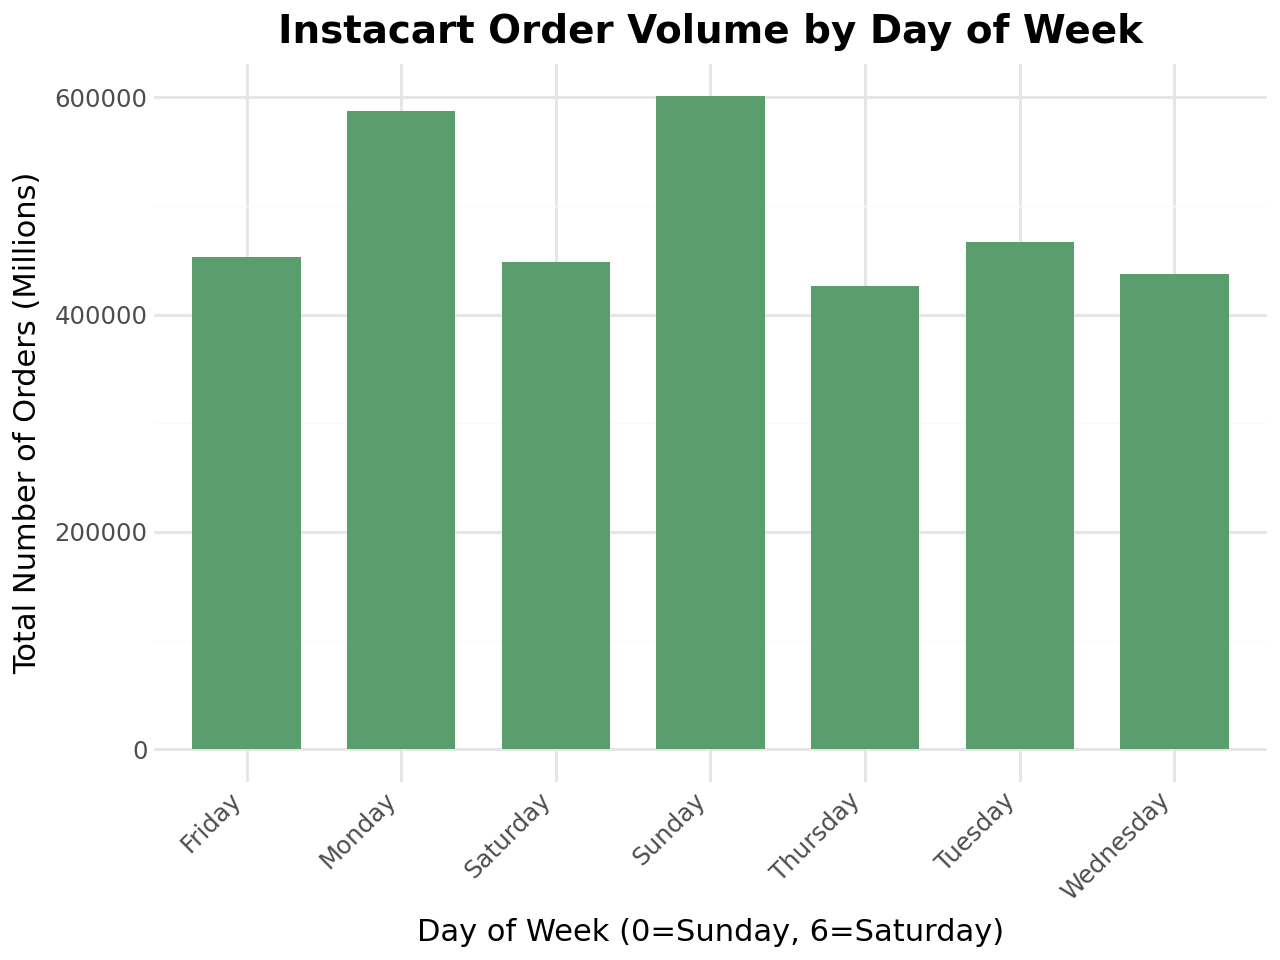

In [22]:

from IPython.display import display



# … (plotnine code to create 'plot')



display(plot)

In [23]:
from plotnine import ggplot, aes, geom_histogram, labs, theme_minimal, scale_x_continuous

# Assuming your 'orders' DataFrame is loaded from 'orders.csv'

plot_hour = (
    ggplot(orders, aes(x='order_hour_of_day'))
    # Use geom_histogram to show frequency distribution
    + geom_histogram(binwidth=1, fill='#3498db', color='black', alpha=0.7) 
    + scale_x_continuous(breaks=range(0, 24, 2)) # Show every 2 hours
    + labs(
        title='Distribution of Order Volume by Hour of Day',
        x='Hour of Day (0 to 23)',
        y='Total Number of Orders'
    )
    + theme_minimal()
)

print(plot_hour)

<ggplot: (640 x 480)>


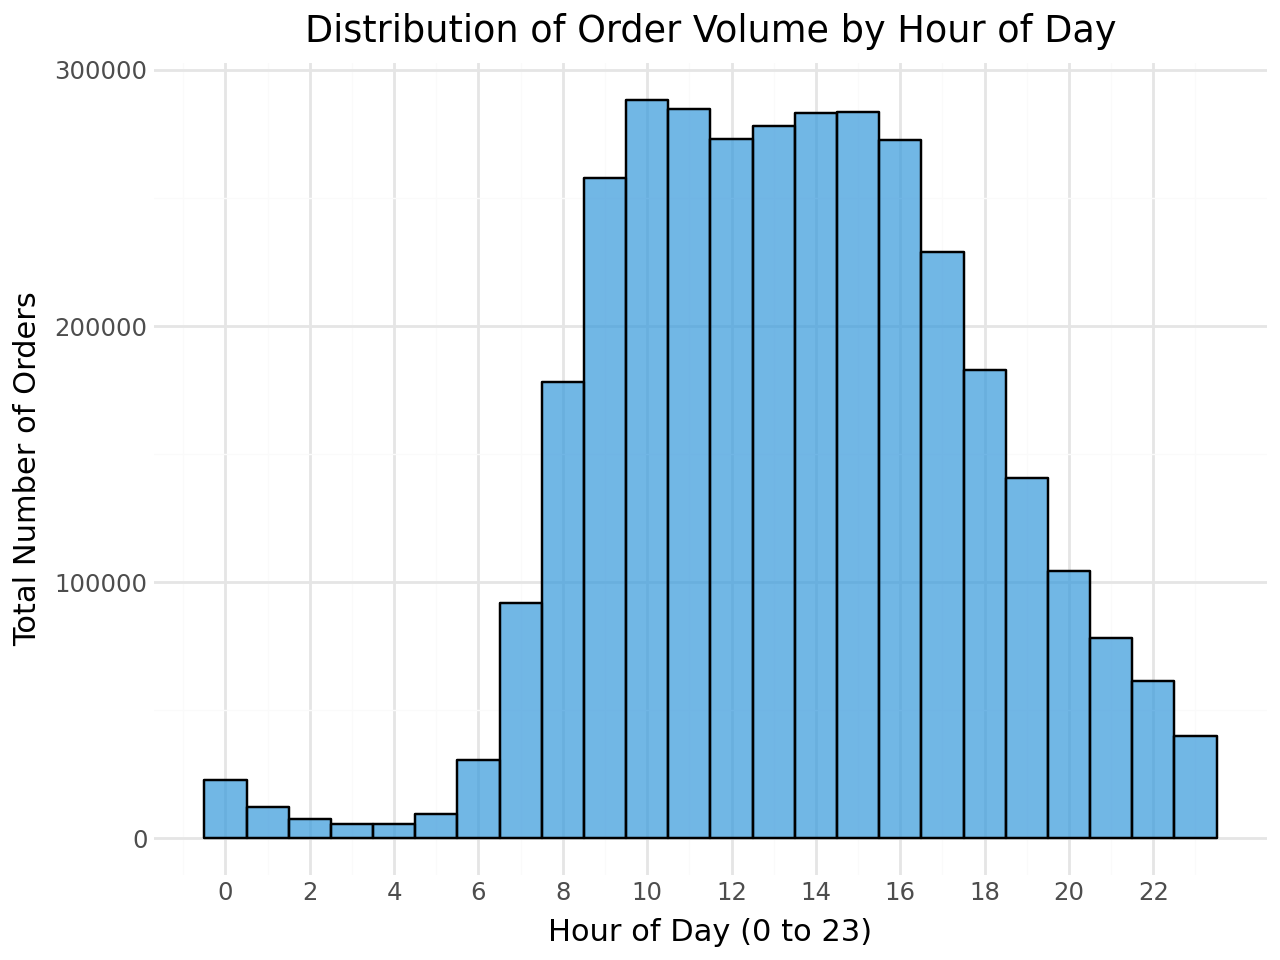

In [25]:

from IPython.display import display



# … (plotnine code to create 'plot')



display(plot_hour)

<ggplot: (640 x 480)>


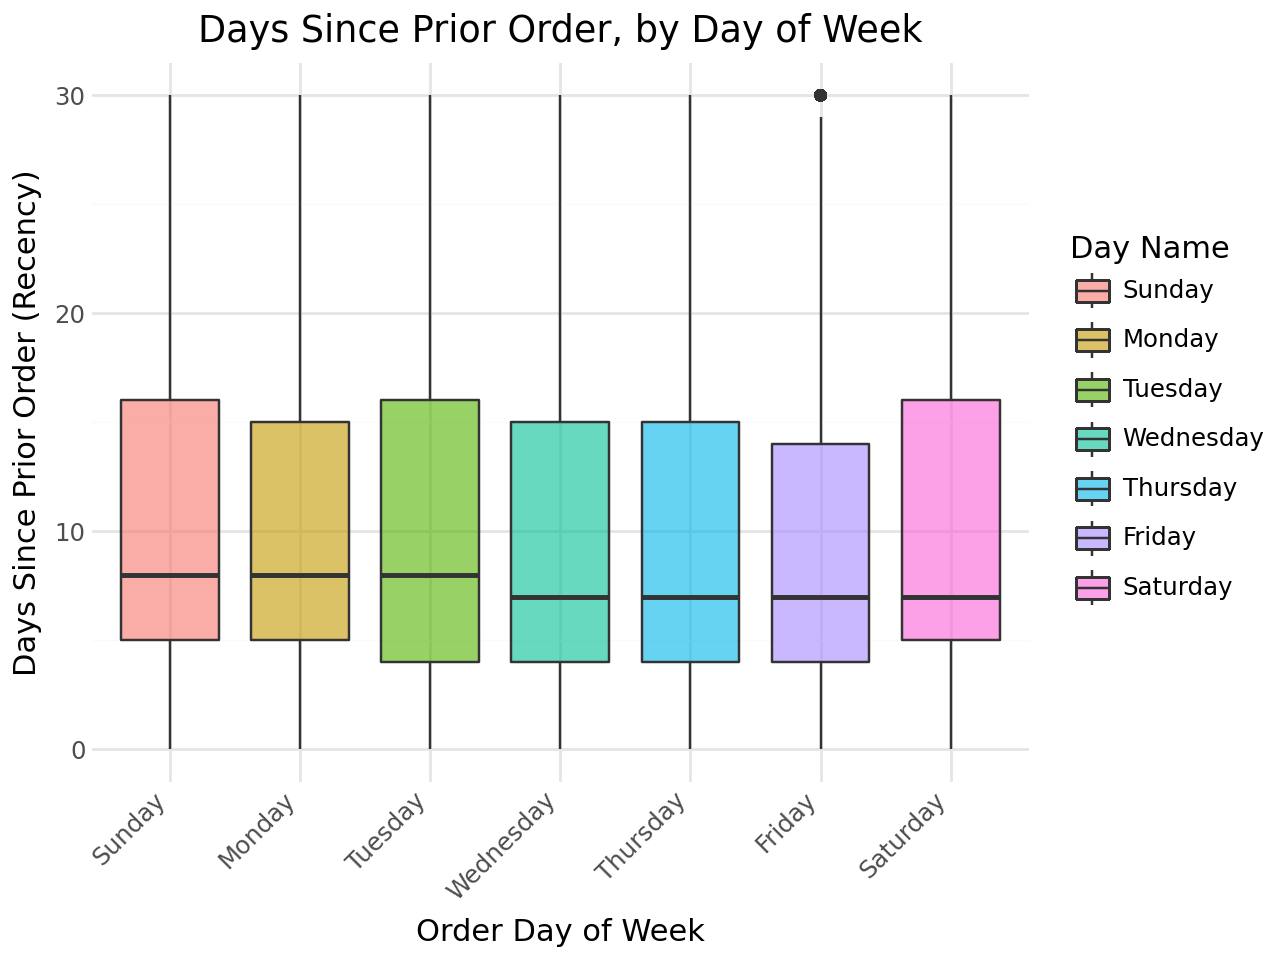

In [29]:
from plotnine import (
    ggplot,
    aes,
    geom_boxplot,
    labs,
    theme_minimal,
    theme,
    element_text,
    guides
)

plot_box = (
    ggplot(df_days, aes(x='day_name', y='days_since_prior_order', fill='day_name'))
    + geom_boxplot(alpha=0.6)
    + labs(
        title='Days Since Prior Order, by Day of Week',
        x='Order Day of Week',
        y='Days Since Prior Order (Recency)',
        fill='Day Name'
    )
    + theme_minimal()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + guides(fill=None)   # ✅ Correct way to hide legend
)

print(plot_box)
display(plot_box)




<ggplot: (640 x 480)>


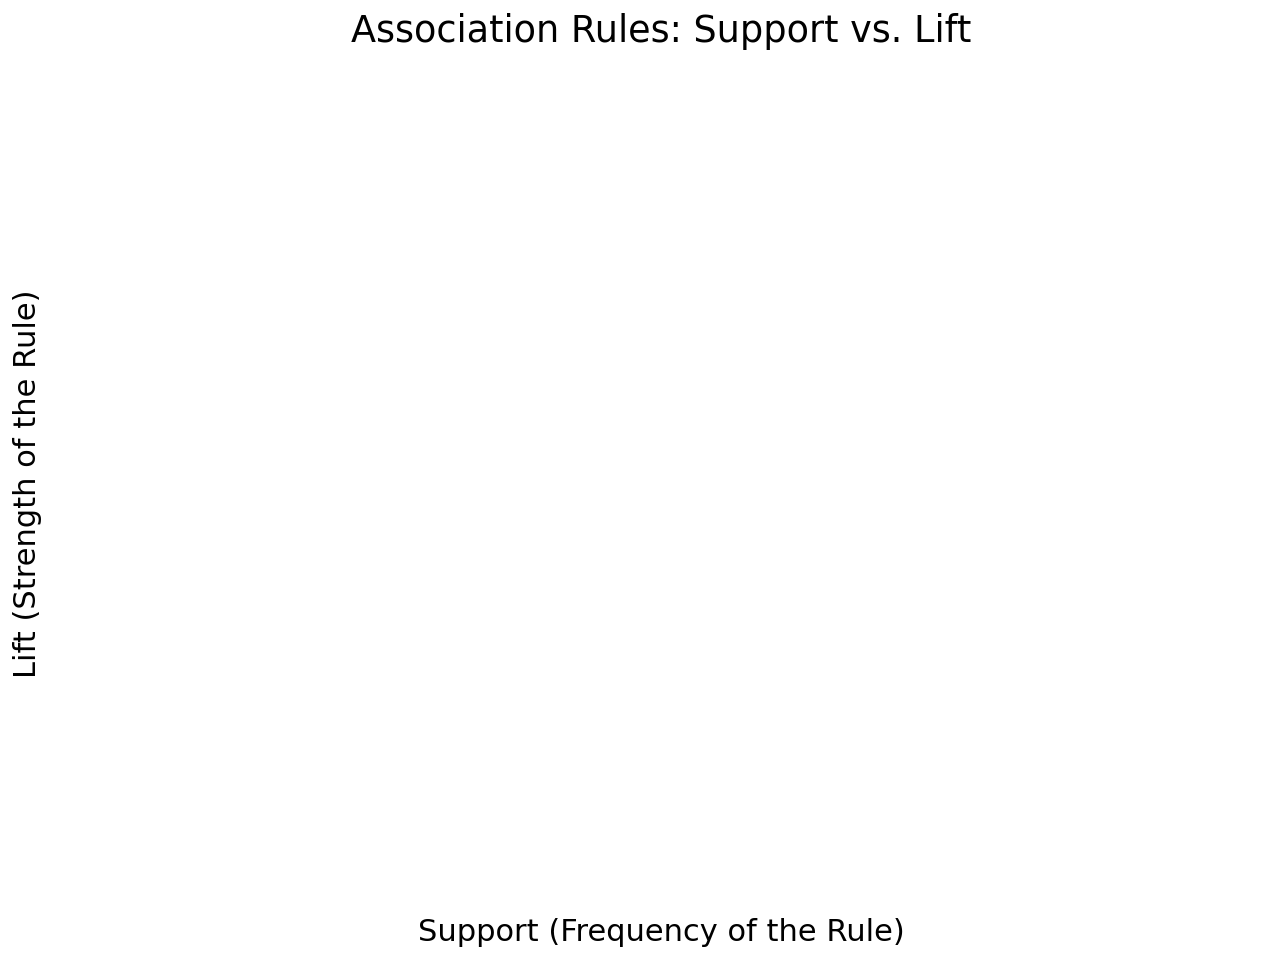

In [30]:
from plotnine import geom_point, scale_size_continuous

# Assuming your 'rules' DataFrame is created and cleaned
# Filter for rules with reasonable metrics (e.g., Lift > 1.5)
rules_filtered = rules[rules['lift'] > 1.5]

plot_scatter = (
    ggplot(rules_filtered, aes(x='support', y='lift', color='confidence', size='confidence'))
    # Use geom_point to map two continuous variables
    + geom_point(alpha=0.6) 
    + scale_size_continuous(range=[2, 8]) # Control the size of points based on confidence
    + labs(
        title='Association Rules: Support vs. Lift',
        x='Support (Frequency of the Rule)',
        y='Lift (Strength of the Rule)',
        color='Confidence'
    )
    + theme_minimal()
)

print(plot_scatter)
display(plot_scatter)